In [ ]:
cd gamedata

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

# Used for normalization
from sklearn import preprocessing

# Used to shuffle data
import random

# Used to perform dimensionality reduction
from sklearn.decomposition import PCA

# Used for spectral clustering
from sklearn.cluster import SpectralClustering

In [3]:
# File name should probably be read in as an argument to a function
datafile = "total_game_data2.csv"

df = pd.read_csv(datafile)
df.head()

,Class,HR min [bpm],HR avg [bpm],HR max [bpm],HR min [%],HR avg [%],HR max [%],Time in HR zone 1 (50 - 59 %),Time in HR zone 2 (60 - 69 %),Time in HR zone 3 (70 - 79 %),...,Number of accelerations (-1.99 - -1.00 m/s),Number of accelerations (-0.99 - -0.50 m/s),Number of accelerations (0.50 - 0.99 m/s),Number of accelerations (1.00 - 1.99 m/s),Number of accelerations (2.00 - 2.99 m/s),Number of accelerations (3.00 - 50.00 m/s),Calories [kcal],Training load score,Recovery time [h],Min Played
0,Forward,37,148,210,19,74,105,0:19:22,0:27:11,0:56:50,...,399,762,593,389,119,19,1343,230,46.0,99
1,Midfielder,62,98,188,31,49,94,0:23:49,0:08:11,0:08:23,...,82,239,211,69,12,0,495,30,5.5,0
2,Forward,80,150,217,40,75,109,0:28:32,0:20:40,0:15:03,...,302,601,500,333,97,11,1407,289,135.7,82
3,Defender,86,150,200,43,75,100,0:19:42,0:15:29,0:19:19,...,352,590,647,360,77,12,1462,302,151.4,79
4,Defender,83,121,192,42,61,96,1:23:38,0:25:26,0:11:26,...,129,325,276,118,21,7,1019,118,21.3,7


In [4]:
# Removes every row where a player had zero minutes played
df = df[df['Min Played'] != 0]

In [5]:
#Drop unnecessary columns (one line?)
df = df[df.columns.drop(list(df.filter(regex='Time')))]
df = df[df.columns.drop(list(df.filter(regex='HR')))]
df = df[df.columns.drop(list(df.filter(regex='Calories')))]
df = df[df.columns.drop(list(df.filter(regex='load score')))]
df = df[df.columns.drop(list(df.filter(regex='Recovery')))]
df = df[df.columns.drop(list(df.filter(regex='Speed zone 1')))]

#Reset index for df
df = df.reset_index(drop=True)

# Shuffle the data
[m,n] = df.shape
df = df.sample(frac=1)

In [6]:
labels = df['Class']
df = df[df.columns.drop(list(df.filter(regex='Class')))]

In [7]:
# Column names to use in later loop
distance_columns = ('Distance in Speed zone 2 [yd] (0.10 - 2.59 mph)', 'Distance in Speed zone 3 [yd] (2.60 - 5.13 mph)', 'Distance in Speed zone 4 [yd] (5.14 - 8.38 mph)', 'Distance in Speed zone 5 [yd] (8.39- mph)')
accel_columns = ('Number of accelerations (-50.00 - -3.00 m/s)', 'Number of accelerations (-2.99 - -2.00 m/s)', 'Number of accelerations (-1.99 - -1.00 m/s)', 'Number of accelerations (-0.99 - -0.50 m/s)', 'Number of accelerations (0.50 - 0.99 m/s)', 'Number of accelerations (1.00 - 1.99 m/s)', 'Number of accelerations (2.00 - 2.99 m/s)', 'Number of accelerations (3.00 - 50.00 m/s)')

# Create new column for total accelerations
df['Total accelerations'] = pd.Series(np.random.randn(len(df)), index=df.index)

# Convert column dtypes to floats for percentage values
df['Sprints'] = df['Sprints'].apply(np.float64)
for i in distance_columns:
    df[i] = df[i].apply(np.float64)
for i in accel_columns:
    df[i] = df[i].apply(np.float64)

# Adjust sprints for minutes played, adjust speed zones for total distance, and get total accelerations
for index, row in df.iterrows():
    # Initialize total acceleration value
    total_accels = 0
    # Change # of sprints to sprints per min
    df.at[index, 'Sprints'] = row['Sprints'] / row['Min Played']
    # Divide distance in speed zone by total distance, save back in speed zone column
    for i in distance_columns:
        df.at[index, i] = (row[i]) / int(row['Total distance [yd]'])
    # Calculate total # of accelerations and save in new column
    for i in accel_columns:
        total_accels += row[i]
    df.at[index, 'Total accelerations'] = total_accels

# Second loop to divide each acceleration column by the total accelerations, save back in acceleration columns
for index, row in df.iterrows():
    for i in accel_columns:
        df.at[index, i] = (row[i]) / int(row['Total accelerations'])
        
df = df[df.columns.drop(list(df.filter(regex='Total distance')))]
df = df[df.columns.drop(list(df.filter(regex='Distance / min')))]
df = df[df.columns.drop(list(df.filter(regex='Average')))]
df = df[df.columns.drop(list(df.filter(regex='Min Played')))]
df = df[df.columns.drop(list(df.filter(regex='Total accelerations')))]
df = df[df.columns.drop(list(df.filter(regex='Speed zone 4')))]
df = df[df.columns.drop(list(df.filter(regex='2.00 - 2.99')))]
df = df[df.columns.drop(list(df.filter(regex='Max')))]
df = df[df.columns.drop(list(df.filter(regex='-1.99 - -1.00')))]
df = df[df.columns.drop(list(df.filter(regex='1.00 - 1.99')))]
df = df[df.columns.drop(list(df.filter(regex='-2.99 - -2.00')))]

df.head()


,Sprints,Distance in Speed zone 2 [yd] (0.10 - 2.59 mph),Distance in Speed zone 3 [yd] (2.60 - 5.13 mph),Distance in Speed zone 5 [yd] (8.39- mph),Number of accelerations (-50.00 - -3.00 m/s),Number of accelerations (-0.99 - -0.50 m/s),Number of accelerations (0.50 - 0.99 m/s),Number of accelerations (3.00 - 50.00 m/s)
91,0.224138,0.143086,0.317112,0.190748,0.004981,0.302615,0.277086,0.003736
103,0.461538,0.221191,0.321259,0.121576,0.004854,0.344660,0.281553,0.002427
6,0.208791,0.130996,0.285316,0.185345,0.002831,0.323779,0.288040,0.004600
16,0.415385,0.131507,0.321178,0.204439,0.005944,0.316415,0.273434,0.006859
62,0.120690,0.165291,0.283117,0.177182,0.008146,0.289890,0.288931,0.001917


In [8]:
# Normalize

x = df.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

# Save changes in new csv to view later
df.to_csv("altered_total.csv")

In [9]:
# Reduce to two dimensions (uses data from every column, are they all really needed / does this overfit???)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# Add the labels back to the df
finalDf = pd.concat([principalDf, labels], axis = 1)

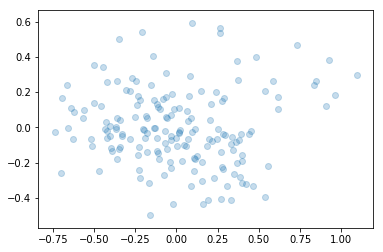

In [10]:
# Store dimensions of dataframe and convert to an array
[m,n] = finalDf.shape
df_array = finalDf.values

# Columns to be used for clustering
ind1 = 0; ind2 = 1

X = np.zeros((m,2))
X[:,0] = df_array[:,ind1]
X[:,1] = df_array[:,ind2]

plt.scatter( X[:,0],X[:,1], alpha=0.25 )

In [11]:
def shape_assign(labels):
    shape_labels = []
    for i in labels:
        if(i == 'Forward'):
            shape_labels.append('x')
        elif(i == 'Midfielder'):
            shape_labels.append('^')
        elif(i == 'Defender'):
            shape_labels.append('.')
    return shape_labels

markers = shape_assign(labels)

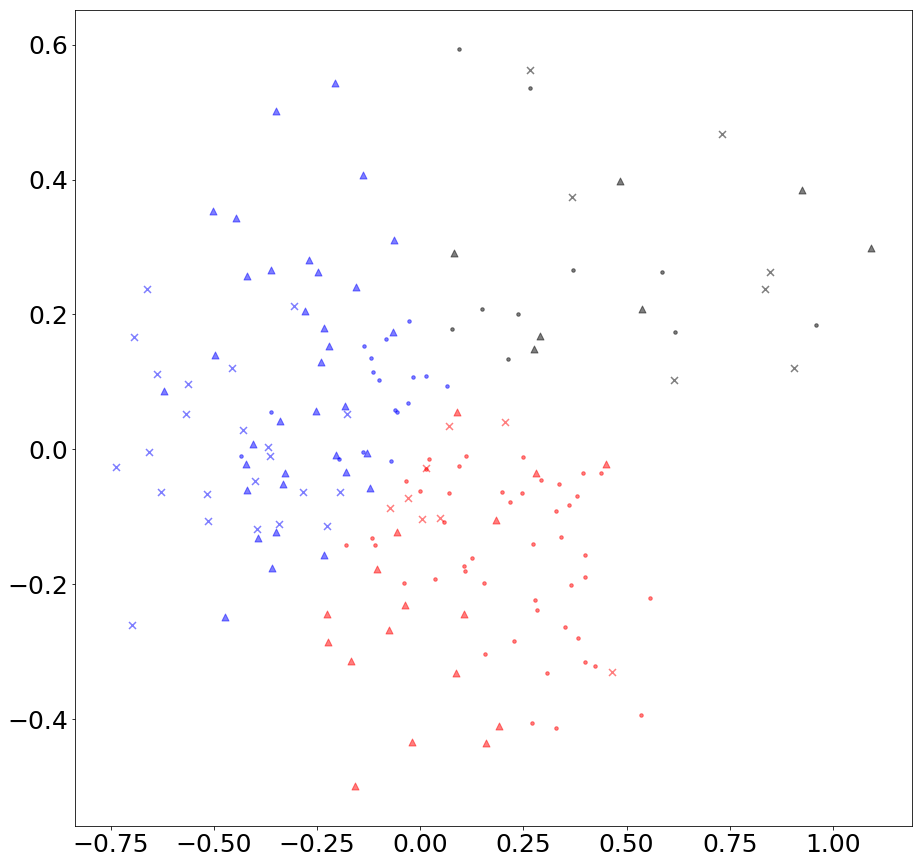

In [12]:
# Scatter plot customization
plt.rcParams['figure.figsize'] = (15,15) 
plt.rcParams['font.size'] = 25 
plt.rcParams['lines.markersize'] = 7

# Spectral clustering code
spectral = SpectralClustering( n_clusters=3 ) # instantiate the k-means model, with 3 clusters
spectral.fit(X) # build the model # plot the results!

x = X[:,0]
y = X[:,1]

def assign_color(labels):
    colors = []
    for i in labels:
        if i == 0:
            colors.append('r')
        elif i == 1:
            colors.append('b')
        elif i == 2:
            colors.append('k')
    return colors
 
col = assign_color(spectral.labels_)

for i in range(len(X)):
    plt.scatter(x[i], y[i], c=col[i], marker=markers[i], alpha=0.5)